In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *
import tifffile

from scipy.signal import convolve2d

# légerement mieux que plt (mais c'est basé sur plt bien sur) et permet de rajouter une scalebar 
# import microfilm.microplot as microplt

# import mpl_scatter_density # pas utile pour nos données


nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
p = plt.rcParams
p['axes.grid'] = False
p['xtick.bottom'] = False
p['xtick.labelbottom'] = False
p['ytick.left'] = False
p['ytick.labelleft'] = False

In [4]:
# id,frame,x [nm],y [nm],sigma [nm],intensity [photon],amplitude [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
id, frame, x, y, sigma, intensity, amplitude, offset, bkgstd, uncertainty_xy = np.loadtxt("../data/microtubules/Acquisition-5/CoordTable_SAFE180_2D.csv",
                                                                                          unpack=True, delimiter=',', skiprows=1)

Pas utile pour nos données

In [16]:
# def using_mpl_scatter_density(fig, x, y):
#     ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
#     density = ax.scatter_density(x, y, cmap='inferno')
#     fig.colorbar(density, label='Number of points per pixel')

# fig = plt.figure()
# using_mpl_scatter_density(fig, x, y)
# plt.show()

Interesting: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
In the end wasn't that useful

Approach which was actually used in research: https://colab.research.google.com/drive/14OCvRUAUFp9JXK6HVyj18fndGY92-Dsx?usp=sharing#scrollTo=6SvsgDkeuXph

Ou sinon on utilise le TIFF

In [17]:
print(x)

[69733.766 62030.887 83515.797 ...  8306.742  6711.708 22672.318]


In [16]:
pixel_recon_dim = 5

# We find the minimum X and Y values in our dataset. They will be used to shift
# all data points to the left or up.
min_x = np.floor(np.min(x))
min_y = np.floor(np.min(y))
x -= min_x
y -= min_y

# We determine the maximum X and Y coordinates to generate proper histograms.
min_x = 0
min_y = 0
max_x = np.ceil(np.max(x))
max_y = np.ceil(np.max(y))

hist_original = np.histogram2d(x,y, range=[[min_x, max_x], [min_y, max_y]],
                                    bins=[int(max_x/pixel_recon_dim), int(max_y/pixel_recon_dim)],
                                    weights=intensity)

# Convolution kernels are two dimensional arrays (here 3x3 and 5x5)
# by which we will possibly convolve the two-dimensional histogram later.
kernel_3x3 = [
    [0,1,0],
    [1,2,1],
    [0,1,0]
]

kernel_5x5 = [
    [0,0,1,0,0],
    [0,1,2,1,0],
    [1,2,3,2,1],
    [0,1,2,1,0],
    [0,0,1,0,0]
]

# To convolve the histogram with one of the kernels we use the convolve2d
# function from the SciPy library. The output has the same dimensions as the
# original histogram due to specifying the convolution mode to 'same'
histogram_convolved = convolve2d(hist_original[0], kernel_3x3, mode='same')
H, W = np.shape(histogram_convolved.T)


In [19]:
print(H,W)

17840 17827


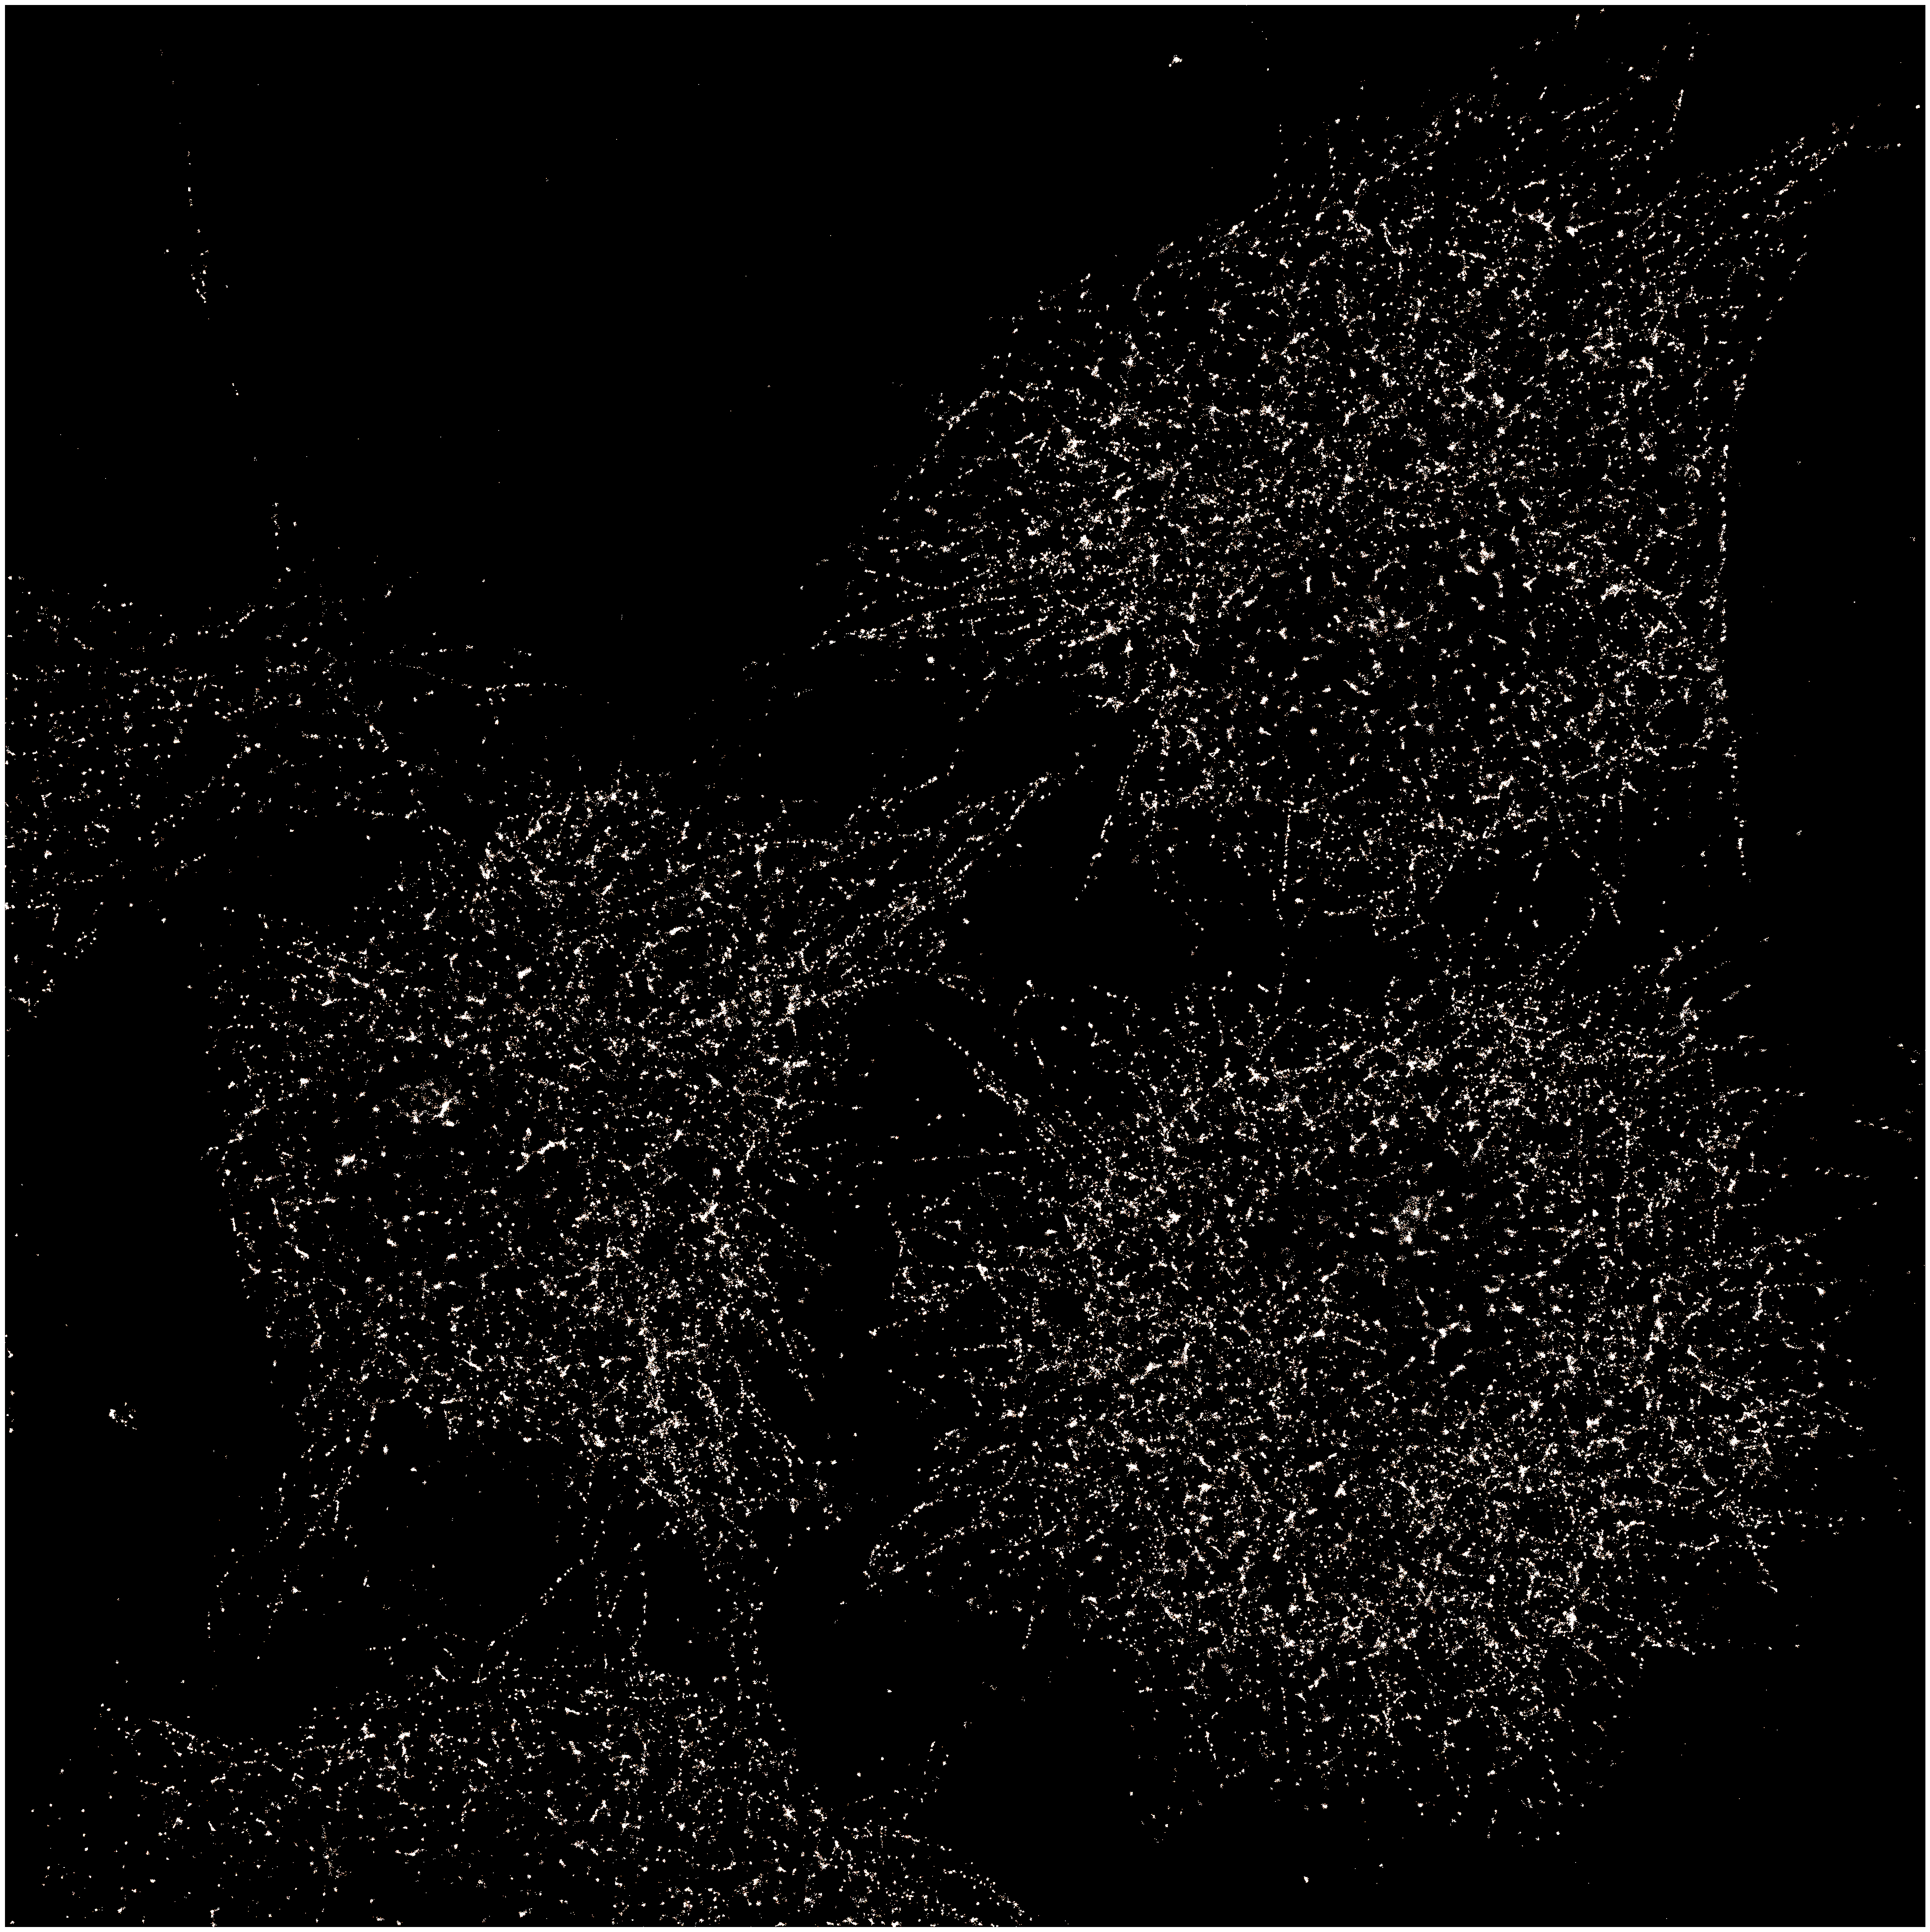

In [ ]:
# The result of the convolved histogram is plotted.
plt.figure(figsize=(50,50))
plt.imshow(histogram_convolved.T, vmax=20, cmap='afmhot')
plt.axis('off')
# plt.savefig("../figures/test_convolution.pdf")

## Linear interpolation method

In [22]:
# First, an empty two-dimensional array is allocated. It will be populated with
# datapoints and finally will be used for the image reconstruction.
# Its dimensions are adjusted to the maximum X and Y coordinate values in
# the dataset divided by the pixel dimensions
hist_2d = np.zeros((int(max_x/pixel_recon_dim)+3, int(max_y/pixel_recon_dim)+3))

# We prepare the method which will compute the amount of intensity which will
# be received by the pixel based on the subpixel localization of the processed event
def interpolation_value(x, pixel_dim=10):
    y = (-np.abs(x)/pixel_dim + 1)
    return y

# In this for loop each datapoint is assigned to four pixels (and in very
# exceptional cases to a single pixel if it is positioned at the center of
# the reconstruction iamge pixel) in the image reconstruction.
for i, boh  in enumerate(x):
# Based on X and Y coordinates we determine the pixel position by dividing the
# coordinates with the floor division (//) operation...
    coord_x = int(x[i] // pixel_recon_dim) + 1
    coord_y = int(y[i] // pixel_recon_dim) + 1
    # ... and also we determine the subpixel pisition of the event. We subtract
    # the halved pixel dimension value from X and Y subpixel position in order
    # to determine how the event is oriented with respect to the pixel center.
    # This value will be used  for the intensity distribution and finding
    # neighboring pixels which will receive a fraction of this intensity as well
    position_x = x[i] % pixel_recon_dim - pixel_recon_dim/2
    position_y = y[i] % pixel_recon_dim - pixel_recon_dim/2

    # we calculate the 'pixel-intensity' which is used for the linear interpolation
    x_int = interpolation_value(position_x)
    y_int = interpolation_value(position_y)

    # Finally we distribute even itnensities to pixels.
    # The original pixel is at coord_x and coord_y values
    hist_2d[coord_x, coord_y] += x_int*y_int * intensity[i]

    # The horizontal neighbor pixel is on the right (or left) side of the
    # original pixel, assuming the datapoint is on the right (or left)
    # half of the original pixel.
    if position_x > 0:
        hist_2d[coord_x+1, coord_y] += (1-x_int)*y_int * intensity[i]
    else:
        hist_2d[coord_x-1, coord_y] += (1-x_int)*y_int * intensity[i]

    # Similarly we find a vertical neighbor in up & down dimension.
    if position_y > 0:
        hist_2d[coord_x, coord_y+1] += x_int*(1-y_int) * intensity[i]
    else:
        hist_2d[coord_x, coord_y-1] += x_int*(1-y_int) * intensity[i]

    # Finally we find the diagonal neighbors by combining the code used in the
    # horizontal and vertical neighbours
    if position_x > 0:
        if position_y > 0:
            hist_2d[coord_x+1, coord_y+1] += (1-x_int)*(1-y_int) * intensity[i]
        else:
            hist_2d[coord_x+1, coord_y-1] += (1-x_int)*(1-y_int) * intensity[i]
    else:
        if position_y > 0:
            hist_2d[coord_x-1, coord_y+1] += (1-x_int)*(1-y_int) * intensity[i]
        else:
            hist_2d[coord_x-1, coord_y-1] += (1-x_int)*(1-y_int) * intensity[i]

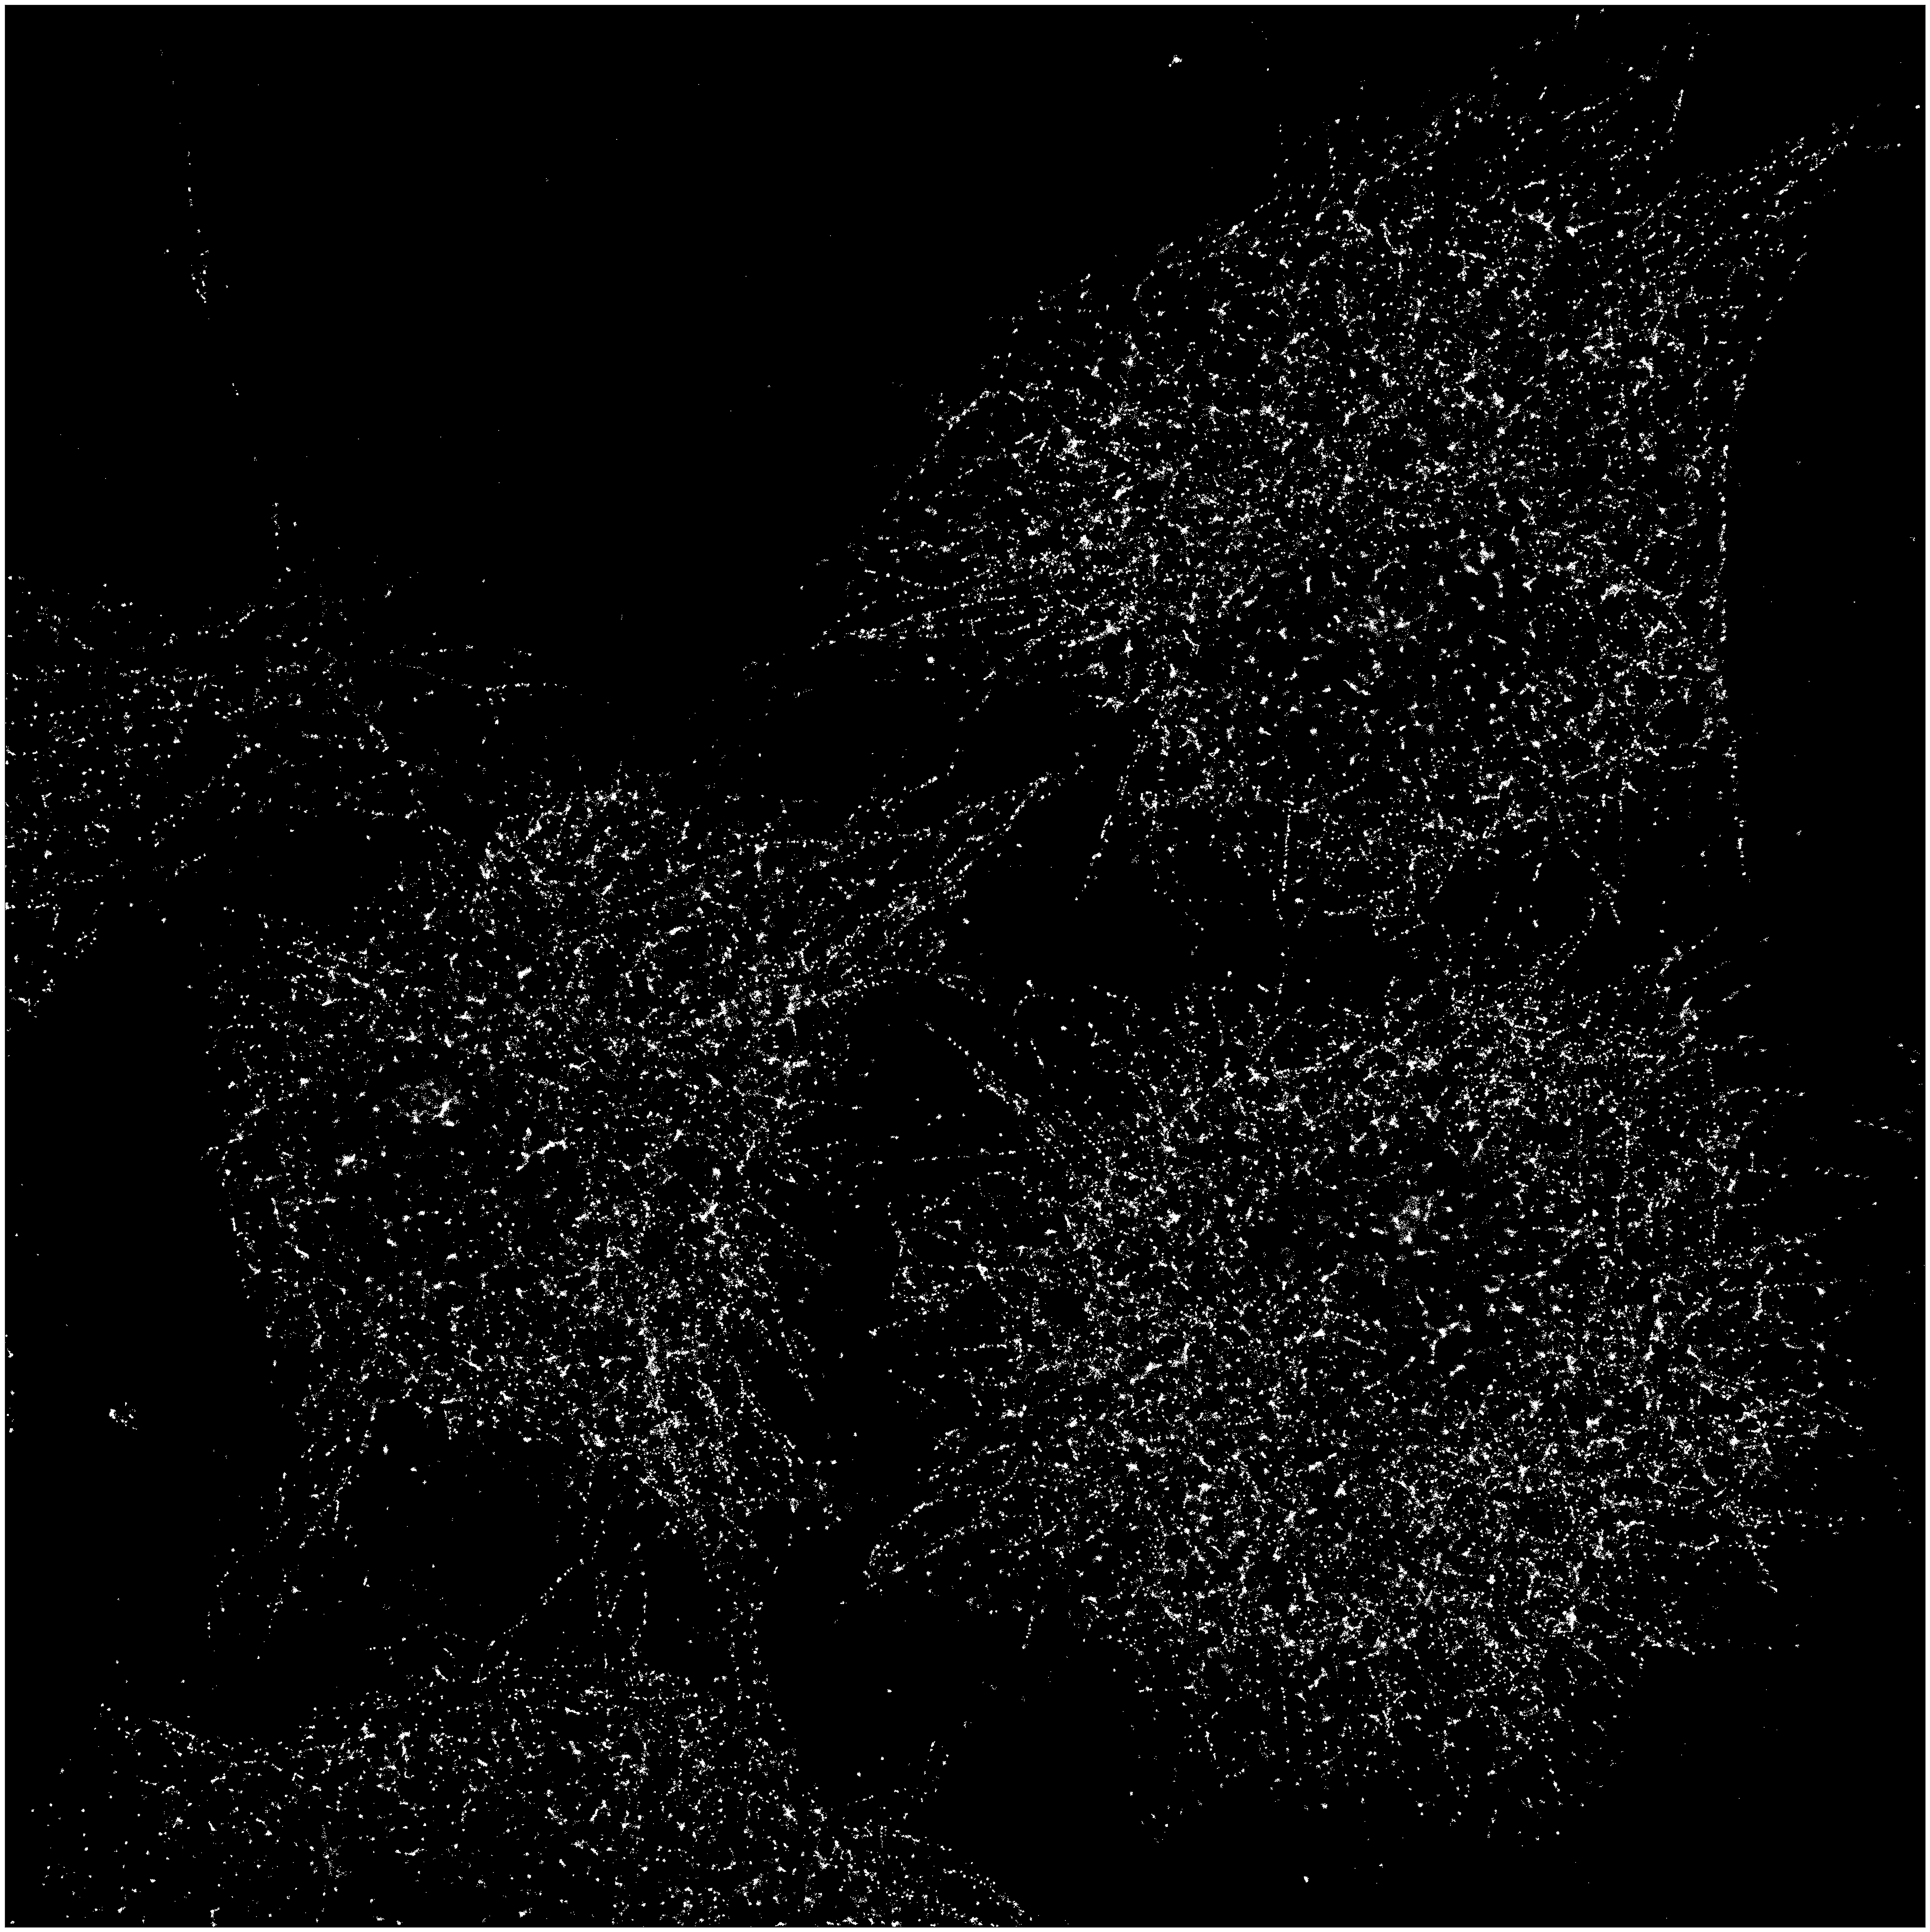

In [35]:
# The result of the linear interpolation visualisation can be plotted.
plt.figure(figsize=(50,50))
plt.imshow(hist_2d.T,vmax=1, cmap='Greys_r');

Ne marche pas trop bien.

## Gaussian rendering

In [17]:
# First, we create an empty image that we will populate with emitters
hist_Gaussian = np.zeros((int(max_x/pixel_recon_dim)+3, int(max_y/pixel_recon_dim)+3))

# Next, we loop over all emitters and increase the image pixels based on the Gaussian profile
for i, boh in enumerate(x):
  #First we re-scale the position based on pixel size
  emitter_info = [x[i]/pixel_recon_dim, y[i]/pixel_recon_dim]
  # Since our data input does not contain emitter-specific localization error information, we have a global value.
  # However, this could reasonably be changed to emitter-specific errors.
  emitter_locerror = 10/pixel_recon_dim #10 nm, rescaled on pixel size
  # We will populate this rendered Gaussian for 3 std each direction, accounting
  # for > 99.7pct of all emitter data. We take size of image into account
  std_gaussian = emitter_locerror
  start_xpos = np.max([round(emitter_info[0]-3*std_gaussian),0])
  end_xpos = np.min([round(emitter_info[0]+3*std_gaussian),np.shape(hist_Gaussian)[0]])
  start_ypos = np.max([round(emitter_info[1]-3*std_gaussian),0])
  end_ypos = np.min([round(emitter_info[1]+3*std_gaussian),np.shape(hist_Gaussian)[1]])

  # Now we loop over these found pixels and increase the value in these pixels
  # based on the gaussian profile and emitter intensity
  for xx in range(start_xpos,end_xpos):
    for yy in range(start_ypos,end_ypos):
      hist_Gaussian[xx,yy] += intensity[i]*np.exp(-((xx-emitter_info[0])**2/(2*std_gaussian**2)+(yy-emitter_info[1])**2/(2*std_gaussian**2)))

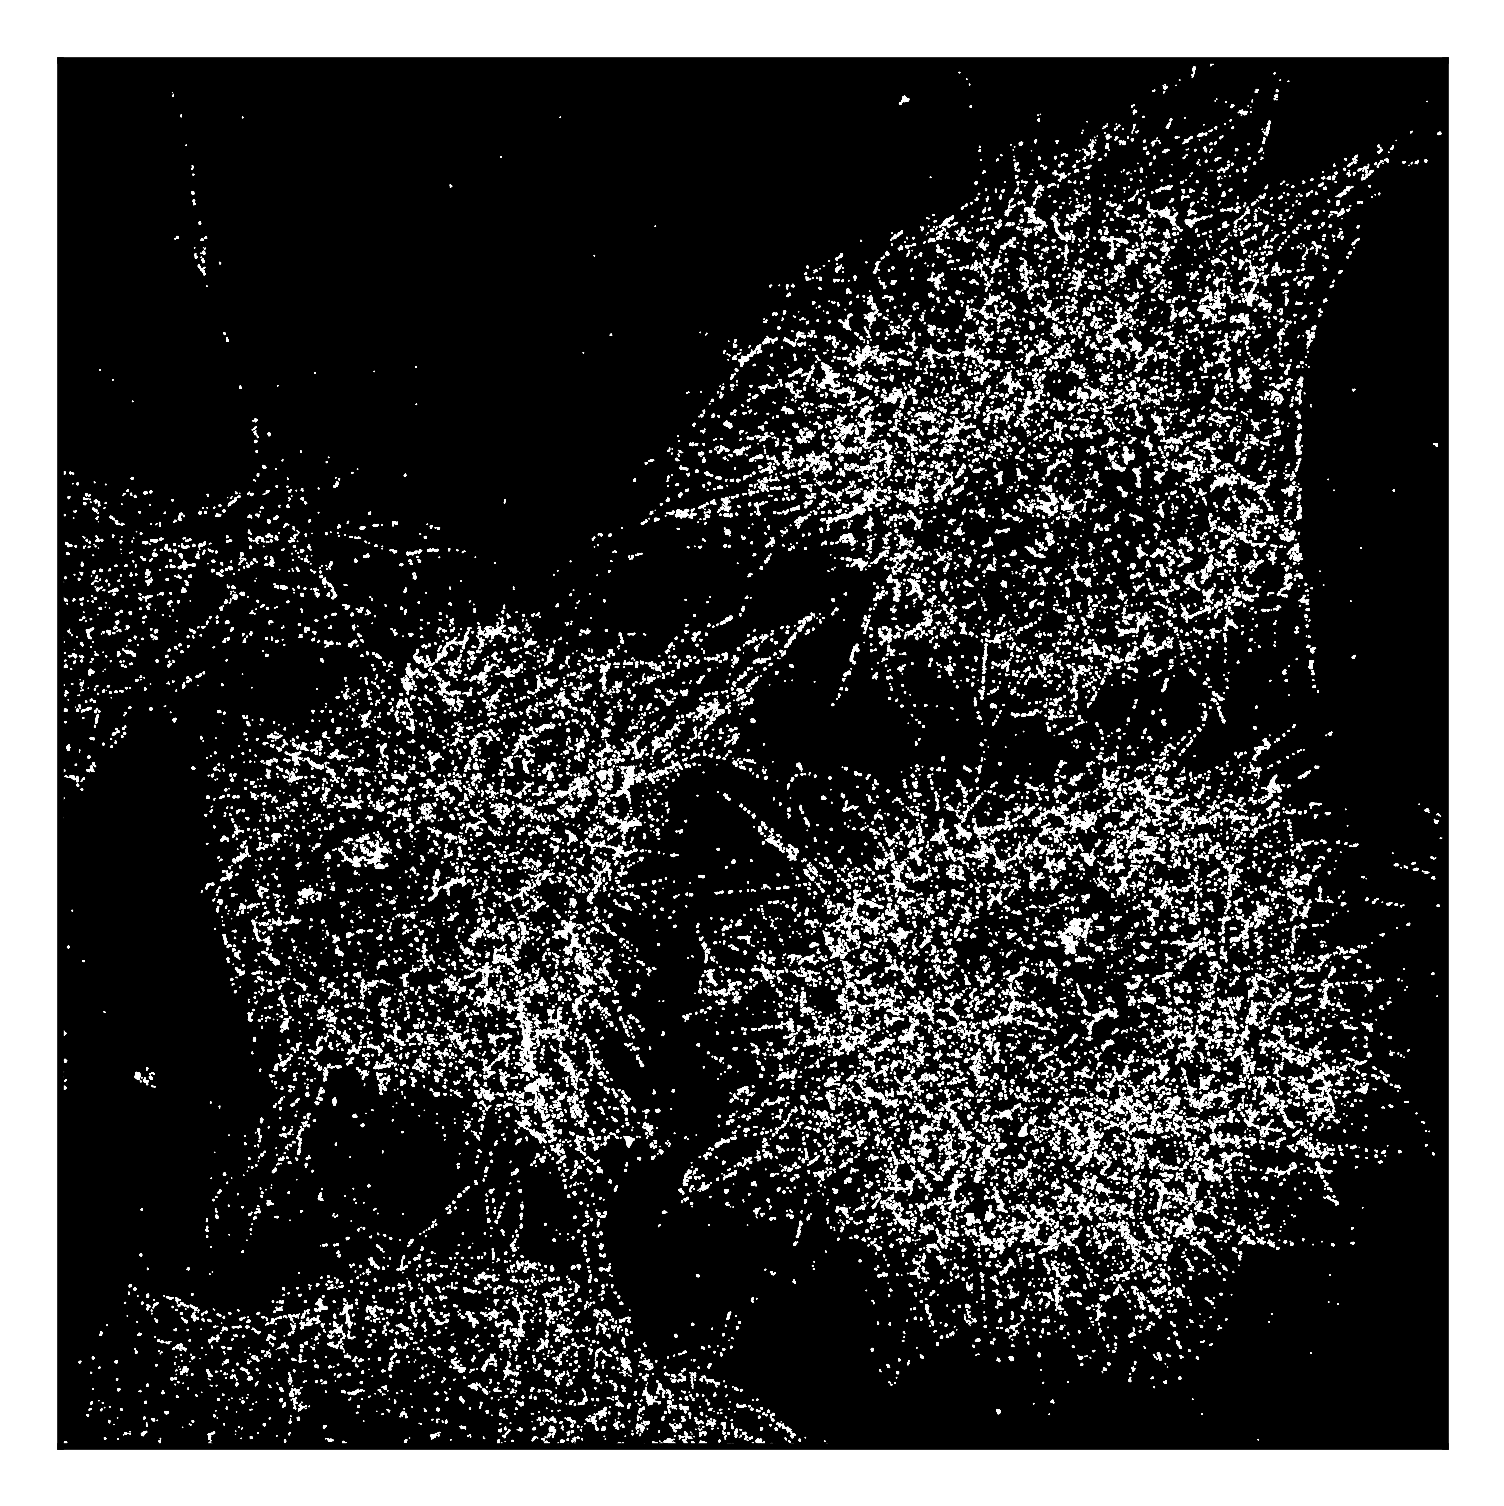

In [ ]:
# The result of the Gaussian rendering visualisation can be plotted.
plt.figure(figsize=(3,3), dpi=600)
plt.imshow(hist_Gaussian.T, vmax=15, cmap='Greys_r');
# plt.savefig("../figures/gaussian_test.png")

Le scatter marche aussi relativement bien

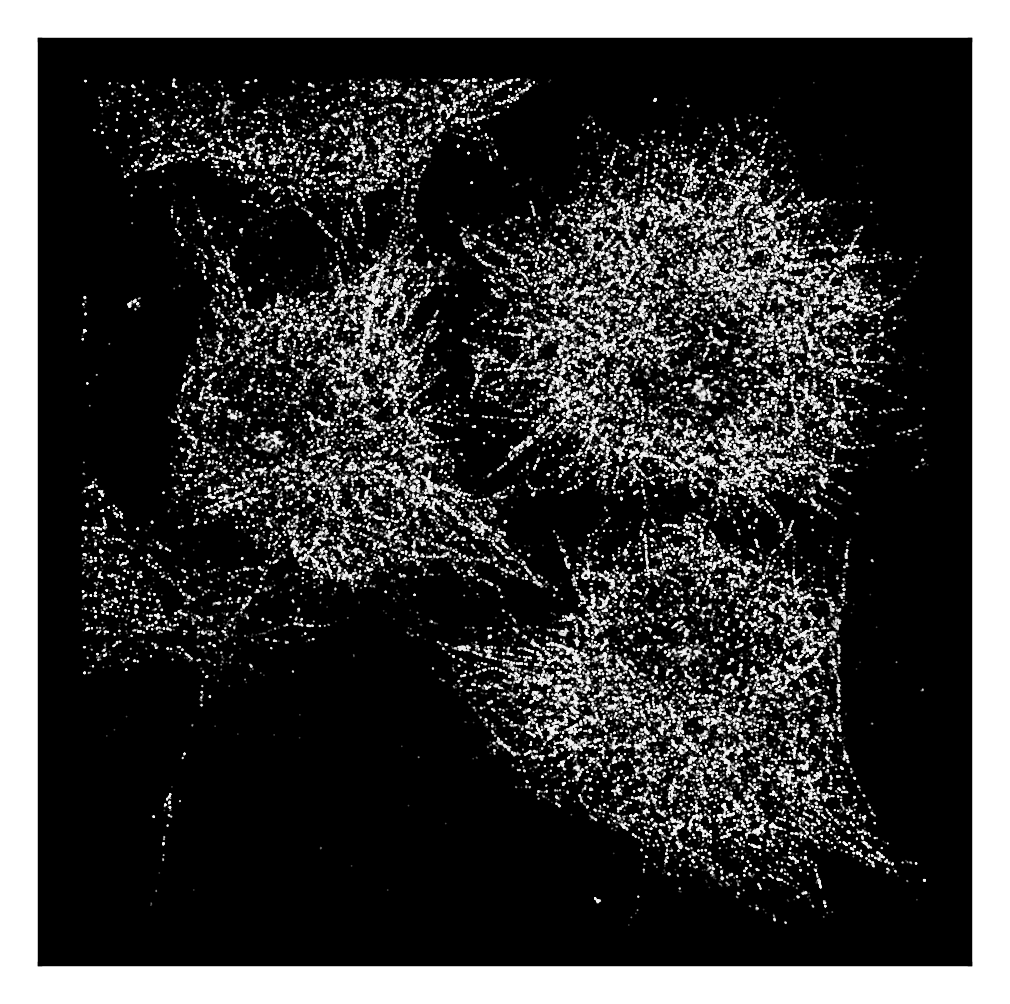

In [ ]:
fig, ax = plt.subplots(figsize=(3,3), dpi=400)
plt.scatter(x,y, marker='.', s=0.4, alpha=0.3, edgecolors='none',
            c=intensity, cmap='Greys')
ax.set_facecolor('black')
plt.xlim(np.min(x), np.max(x))
plt.ylim(np.min(y), np.max(x))
plt.axis("equal")
# plt.savefig("../figures/test_scatter.png")
plt.show()

Le TIFF n'est pas trop mal au final

In [6]:
imdata = tifffile.imread('../data/microtubules/Acquisition-5/NANO2D_pix_15nm.tif')
pix_min = np.min(imdata)
pix_max = np.max(imdata)
normalized_imdata = (imdata - pix_min) / (pix_max - pix_min)
# print(np.mean(normalized_imdata))
# # print(pix_min)
# print(pix_max)
# # print(np.max(normalized_imdata))
# np.sum(normalized_imdata > 0.01)

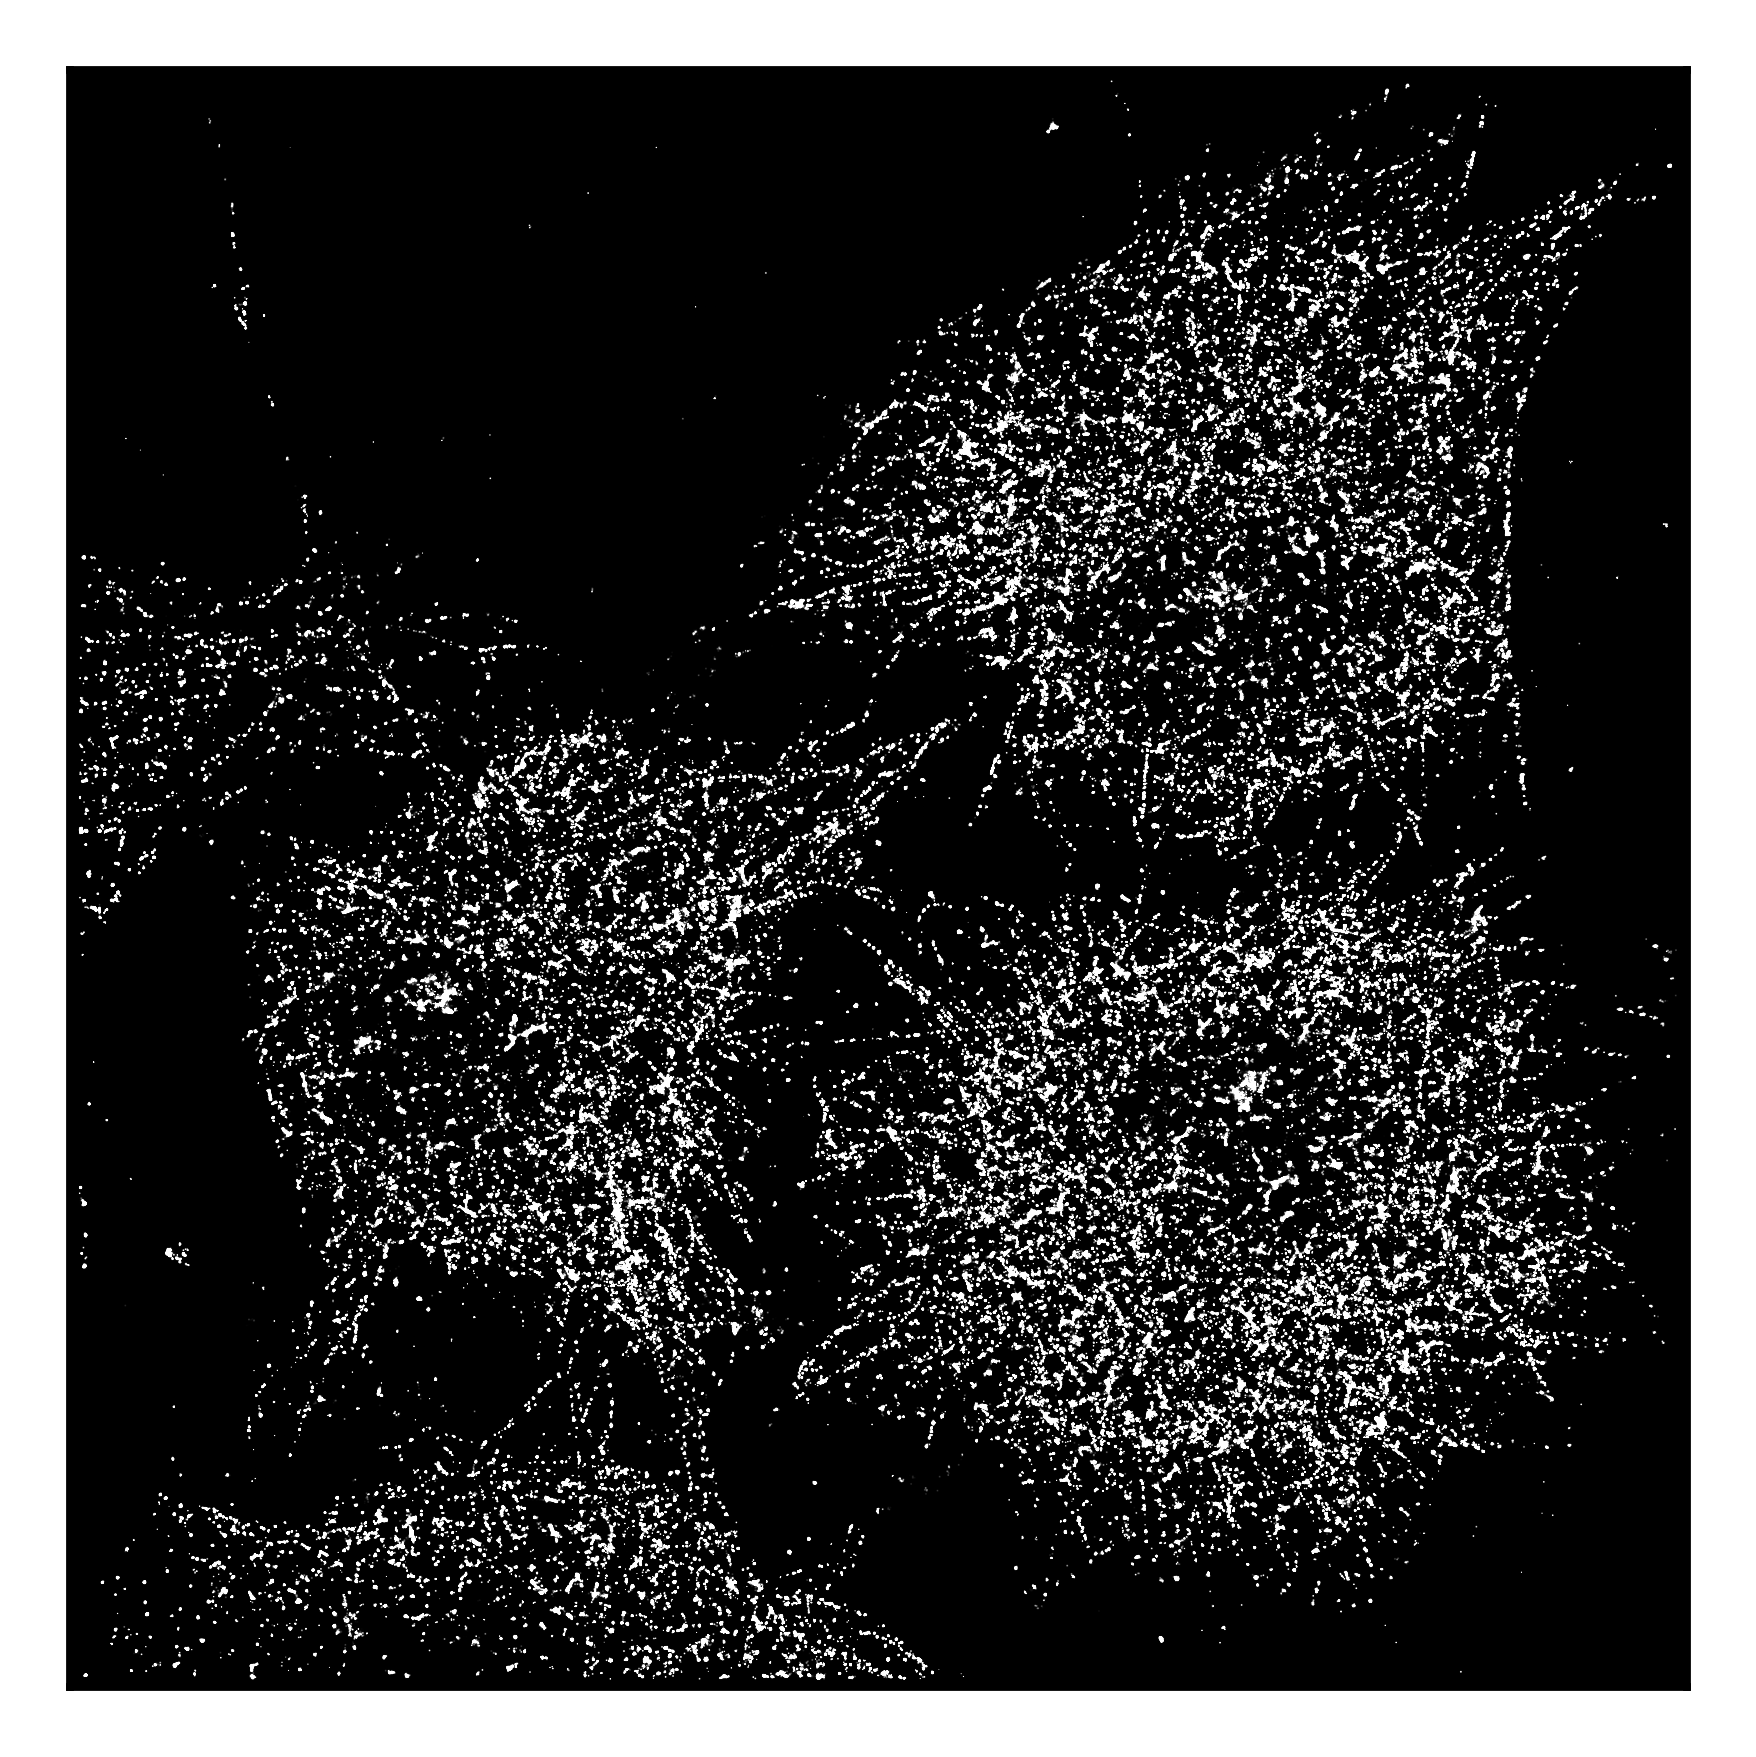

In [ ]:
plt.figure(figsize=(3,3), dpi=700)
plt.imshow(normalized_imdata, cmap=plt.get_cmap('Greys_r'),
           vmax=0.0002)
# plt.colorbar()
plt.grid(False)
# plt.savefig("../figures/test_imshow.png")
plt.show()


Ca c'est le TIFF legerement plus beau

In [27]:
# microim = microplt.microshow(normalized_imdata, limits=[0,0.0007])
# microplt.savefig("../figures/micro.pdf", dpi=700)
